In [2]:
import os
import pandas as pd
import numpy as np

In [3]:
import os
import pandas as pd

# Move up one level from 'scripts/' and access 'data/'
file_path = os.path.join("..", "data", "AER_credit_card_data.csv")

df = pd.read_csv(file_path)

### Why logistic regression

Used for binary classification (e.g., default vs. no default). 

Predicts a class (0 or 1) based on a probability threshold (e.g., 0.5).

Can interpret feature importance of the coefficients supplied and handles non-linear relationships

## Clean the data and run logisitic regression

In [7]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# ---------------- STEP 1: Load and Prepare Data ---------------- #

# Load the dataset (replace with actual file path)
import os

# Using a relative path (assuming script is in 'scripts/' and data is in 'data/')
file_path = os.path.join("..", "data", "AER_credit_card_data.csv")

# Read the dataset
df = pd.read_csv(file_path)

# Convert categorical values ('yes' → 1, 'no' → 0) for model compatibility
df['card'] = df['card'].map({'yes': 1, 'no': 0})      # Credit approval status
df['owner'] = df['owner'].map({'yes': 1, 'no': 0})    # Homeownership
df['selfemp'] = df['selfemp'].map({'yes': 1, 'no': 0}) # Self-employed status

# Create the 'negative_reports' column (1 = default, 0 = no default)
df['negative_reports'] = np.where(df['reports'] >= 1, 1, 0)

# ---------------- STEP 2: Filter Only Approved Applications ---------------- #

# We only want to build a credit scoring model for **approved applications**
df_approved = df[df['card'] == 1].copy()  # Filter only accepted applications

# Define the new target variable: whether the applicant defaulted
df_approved['default'] = df_approved['negative_reports']  # 1 = Defaulted, 0 = No Default

# Drop unnecessary columns ('card' and 'negative_reports' since they are redundant now)
X = df_approved.drop(columns=['card', 'reports', 'negative_reports', 'default'])  
y = df_approved['default']  # Target variable: default status

# ---------------- STEP 3: Train-Test Split ---------------- #

# Split the dataset into **training (80%) and testing (20%)** sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ---------------- STEP 4: Standardizing Numerical Features ---------------- #

# Identify binary (categorical) columns - We should **not** scale these
binary_columns = ['owner', 'selfemp', 'majorcards']

# Identify continuous columns to be scaled
continuous_columns = [col for col in X.columns if col not in binary_columns]

# Initialize the StandardScaler
scaler = StandardScaler()

# Scale only the continuous columns
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[continuous_columns] = scaler.fit_transform(X_train[continuous_columns])
X_test_scaled[continuous_columns] = scaler.transform(X_test[continuous_columns])

# ---------------- STEP 5: Train the Logistic Regression Model ---------------- #

# Initialize the logistic regression model
model = LogisticRegression()

# Train the model using the training dataset
model.fit(X_train_scaled, y_train)

# ---------------- STEP 6: Make Predictions ---------------- #

# Use the trained model to predict default probabilities
y_pred = model.predict(X_test_scaled)

# ---------------- STEP 7: Evaluate Model Performance ---------------- #

# Calculate accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

# Get a classification report for detailed performance metrics
classification_rep = classification_report(y_test, y_pred)

# Print model evaluation results
print(f"Model Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_rep)

# ---------------- STEP 8: Understanding Feature Importance ---------------- #

# Extract feature importance (coefficients) from logistic regression
coefficients = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": model.coef_[0]
}).sort_values(by="Coefficient", ascending=False)

# Display feature importance
print("\nFeature Importance (Positive = Higher Default Risk, Negative = Lower Default Risk):")
print(coefficients)


Model Accuracy: 0.91
Classification Report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95       187
           1       0.00      0.00      0.00        18

    accuracy                           0.91       205
   macro avg       0.46      0.50      0.48       205
weighted avg       0.83      0.91      0.87       205


Feature Importance (Positive = Higher Default Risk, Negative = Lower Default Risk):
       Feature  Coefficient
9       active     0.675373
7       months     0.365648
1       income     0.356722
2        share     0.271028
5      selfemp     0.253933
0          age    -0.050304
3  expenditure    -0.091003
8   majorcards    -0.096047
6   dependents    -0.245298
4        owner    -0.545164


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Feature importance shows that the number of active accounts has high correlation with eventual default status. 

Homeowners are significantly less likely to default based on this dataset.

## Rerun Model with different variations to improve accuracy and recall

In [8]:
# Train logistic regression with class weighting
model = LogisticRegression(class_weight='balanced')
model.fit(X_train_scaled, y_train)

# Make predictions again
y_pred = model.predict(X_test_scaled)

# Evaluate the updated model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Model Accuracy: {accuracy:.2f}")
print("Updated Classification Report:\n", classification_rep)


Model Accuracy: 0.64
Updated Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.66      0.77       187
           1       0.10      0.39      0.16        18

    accuracy                           0.64       205
   macro avg       0.51      0.53      0.46       205
weighted avg       0.85      0.64      0.72       205



## Oversample the default class

In [9]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance classes
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Train logistic regression on resampled data
model = LogisticRegression()
model.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Evaluate again
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Model Accuracy: {accuracy:.2f}")
print("Classification Report after SMOTE:\n", classification_rep)


Model Accuracy: 0.63
Classification Report after SMOTE:
               precision    recall  f1-score   support

           0       0.92      0.66      0.77       187
           1       0.10      0.39      0.16        18

    accuracy                           0.63       205
   macro avg       0.51      0.52      0.46       205
weighted avg       0.85      0.63      0.71       205



# Run a random forest model

In [10]:
from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred_rf = rf_model.predict(X_test_scaled)

# Evaluate Random Forest
accuracy_rf = accuracy_score(y_test, y_pred_rf)
classification_rep_rf = classification_report(y_test, y_pred_rf)

print(f"Random Forest Accuracy: {accuracy_rf:.2f}")
print("Random Forest Classification Report:\n", classification_rep_rf)



Random Forest Accuracy: 0.82
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.88      0.90       187
           1       0.12      0.17      0.14        18

    accuracy                           0.82       205
   macro avg       0.52      0.52      0.52       205
weighted avg       0.85      0.82      0.83       205



In [11]:
# Get predicted probabilities
y_pred_probs = model.predict_proba(X_test_scaled)[:, 1]  # Probabilities for default (class 1)

# Adjust threshold
threshold = 0.35  # Lowering the default threshold
y_pred_adjusted = (y_pred_probs >= threshold).astype(int)

# Evaluate adjusted predictions
accuracy_adj = accuracy_score(y_test, y_pred_adjusted)
classification_rep_adj = classification_report(y_test, y_pred_adjusted)

print(f"Adjusted Threshold Accuracy: {accuracy_adj:.2f}")
print("Classification Report after Threshold Adjustment:\n", classification_rep_adj)


Adjusted Threshold Accuracy: 0.44
Classification Report after Threshold Adjustment:
               precision    recall  f1-score   support

           0       0.90      0.43      0.58       187
           1       0.08      0.50      0.14        18

    accuracy                           0.44       205
   macro avg       0.49      0.47      0.36       205
weighted avg       0.83      0.44      0.55       205



In [12]:
from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred_rf = rf_model.predict(X_test_scaled)

# Evaluate Random Forest
accuracy_rf = accuracy_score(y_test, y_pred_rf)
classification_rep_rf = classification_report(y_test, y_pred_rf)

print(f"Random Forest Accuracy: {accuracy_rf:.2f}")
print("Random Forest Classification Report:\n", classification_rep_rf)


Random Forest Accuracy: 0.82
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.88      0.90       187
           1       0.12      0.17      0.14        18

    accuracy                           0.82       205
   macro avg       0.52      0.52      0.52       205
weighted avg       0.85      0.82      0.83       205



In [13]:
import numpy as np
from sklearn.metrics import precision_recall_curve

# Get predicted probabilities for Class 1 (default)
y_pred_probs = model.predict_proba(X_test_scaled)[:, 1]

# Get precision-recall values
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_probs)

# Find the best threshold with a balance of precision and recall
best_threshold = thresholds[np.argmax(recalls - precisions)]  # Maximize recall while limiting false positives

# Apply new threshold
y_pred_adjusted = (y_pred_probs >= best_threshold).astype(int)

# Evaluate model again
accuracy_adj = accuracy_score(y_test, y_pred_adjusted)
classification_rep_adj = classification_report(y_test, y_pred_adjusted)

print(f"Optimized Threshold: {best_threshold:.2f}")
print(f"Optimized Threshold Accuracy: {accuracy_adj:.2f}")
print("Classification Report after Optimized Threshold Adjustment:\n", classification_rep_adj)


Optimized Threshold: 0.04
Optimized Threshold Accuracy: 0.09
Classification Report after Optimized Threshold Adjustment:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       187
           1       0.09      1.00      0.16        18

    accuracy                           0.09       205
   macro avg       0.04      0.50      0.08       205
weighted avg       0.01      0.09      0.01       205



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Fine tune random forest parameters

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define parameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced']
}

# Perform Grid Search
rf_tuned = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='recall')
rf_tuned.fit(X_train_resampled, y_train_resampled)

# Best Model
best_rf = rf_tuned.best_estimator_

# Make predictions
y_pred_rf_tuned = best_rf.predict(X_test_scaled)

# Evaluate tuned model
accuracy_rf_tuned = accuracy_score(y_test, y_pred_rf_tuned)
classification_rep_rf_tuned = classification_report(y_test, y_pred_rf_tuned)

print(f"Tuned Random Forest Accuracy: {accuracy_rf_tuned:.2f}")
print("Tuned Random Forest Classification Report:\n", classification_rep_rf_tuned)


Tuned Random Forest Accuracy: 0.76
Tuned Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.81      0.86       187
           1       0.10      0.22      0.14        18

    accuracy                           0.76       205
   macro avg       0.51      0.51      0.50       205
weighted avg       0.84      0.76      0.79       205



# Run XGboost model

In [15]:
from xgboost import XGBClassifier

# Train an XGBoost model with class balancing
xgb_model = XGBClassifier(scale_pos_weight=len(y_train_resampled) / sum(y_train_resampled), use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Evaluate XGBoost model
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
classification_rep_xgb = classification_report(y_test, y_pred_xgb)

print(f"XGBoost Accuracy: {accuracy_xgb:.2f}")
print("XGBoost Classification Report:\n", classification_rep_xgb)


XGBoost Accuracy: 0.79
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.84      0.88       187
           1       0.12      0.22      0.15        18

    accuracy                           0.79       205
   macro avg       0.52      0.53      0.52       205
weighted avg       0.85      0.79      0.81       205



C:\Users\SeanD\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [10:48:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [21]:
xgb_tuned = XGBClassifier(scale_pos_weight=2, max_depth=6, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss', random_state=42, min_child_weight=3)
xgb_tuned.fit(X_train_resampled, y_train_resampled)

y_pred_xgb_tuned = xgb_tuned.predict(X_test_scaled)

accuracy_xgb_tuned = accuracy_score(y_test, y_pred_xgb_tuned)
classification_rep_xgb_tuned = classification_report(y_test, y_pred_xgb_tuned)

print(f"Reduced Scale Pos Weight XGBoost Accuracy: {accuracy_xgb_tuned:.2f}")
print("Reduced Scale Pos Weight XGBoost Classification Report:\n", classification_rep_xgb_tuned)


Reduced Scale Pos Weight XGBoost Accuracy: 0.73
Reduced Scale Pos Weight XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.78      0.84       187
           1       0.11      0.28      0.15        18

    accuracy                           0.73       205
   macro avg       0.51      0.53      0.50       205
weighted avg       0.85      0.73      0.78       205



C:\Users\SeanD\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [10:55:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [22]:
# Get predicted probabilities
y_pred_probs = xgb_tuned.predict_proba(X_test_scaled)[:, 1]

# Adjust threshold to 0.35 (instead of default 0.5)
threshold = 0.35
y_pred_adjusted = (y_pred_probs >= threshold).astype(int)

# Evaluate adjusted predictions
accuracy_adj = accuracy_score(y_test, y_pred_adjusted)
classification_rep_adj = classification_report(y_test, y_pred_adjusted)

print(f"Adjusted Threshold XGBoost Accuracy: {accuracy_adj:.2f}")
print("Classification Report after Adjusted Threshold:\n", classification_rep_adj)


Adjusted Threshold XGBoost Accuracy: 0.67
Classification Report after Adjusted Threshold:
               precision    recall  f1-score   support

           0       0.92      0.70      0.79       187
           1       0.11      0.39      0.17        18

    accuracy                           0.67       205
   macro avg       0.52      0.54      0.48       205
weighted avg       0.85      0.67      0.74       205



Reduced Scale Pos Weight XGBoost Accuracy accuracy yields the best results. Recalled 28% of defaults and model still yields 73% accuracy.

# Convert to Credit Score

In [25]:
# Get predicted default probabilities from the trained XGBoost model
y_pred_probs = xgb_tuned.predict_proba(X_test_scaled)[:, 1]  # Probability of default (class 1)

# Convert probabilities to a credit score (higher probability = lower score)
credit_scores = np.round(1000 * (1 - y_pred_probs)).astype(int)  # Scale to 0-1000 range

# Add credit scores to the test dataset for reference
X_test_with_scores = X_test.copy()
X_test_with_scores['Predicted Default Probability'] = y_pred_probs
X_test_with_scores['Credit Score (0-1000)'] = credit_scores

# If using Jupyter Notebook, display as a DataFrame
X_test_with_scores[['Predicted Default Probability', 'Credit Score (0-1000)']].head(20)

,Predicted Default Probability,Credit Score (0-1000)
677,0.033629,966
467,0.854320,146
573,0.008541,991
40,0.006207,994
797,0.894557,105
761,0.888348,112
577,0.502363,498
946,0.076432,924
105,0.005625,994
923,0.025866,974


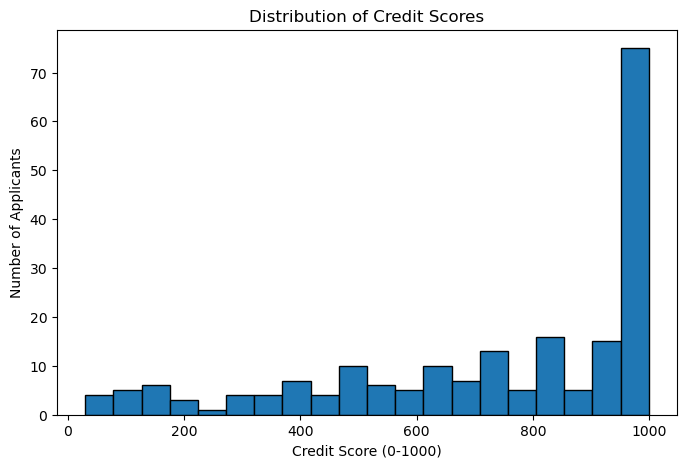

In [26]:
import matplotlib.pyplot as plt

# Plot the distribution of credit scores
plt.figure(figsize=(8,5))
plt.hist(credit_scores, bins=20, edgecolor='black')
plt.xlabel("Credit Score (0-1000)")
plt.ylabel("Number of Applicants")
plt.title("Distribution of Credit Scores")
plt.show()


In [27]:
import numpy as np

def predict_credit_score(model, scaler, applicant_data):
    """
    Predicts the credit score (0-1000) for a new applicant.
    
    Parameters:
    - model: Trained XGBoost model
    - scaler: StandardScaler used to transform the training data
    - applicant_data: Dictionary containing applicant features
    
    Returns:
    - Credit Score (0-1000)
    """

    # Define the expected feature order based on training data
    feature_order = ['age', 'income', 'share', 'expenditure', 'owner', 'selfemp', 
                     'dependents', 'months', 'majorcards', 'active']

    # Convert dictionary to a NumPy array (keeping the correct feature order)
    input_features = np.array([[applicant_data[feature] for feature in feature_order]])

    # Scale numerical features (skip binary categorical variables)
    continuous_columns = ['age', 'income', 'share', 'expenditure', 'dependents', 'months', 'active']
    input_features[:, [feature_order.index(col) for col in continuous_columns]] = scaler.transform(input_features[:, [feature_order.index(col) for col in continuous_columns]])

    # Get the default probability from the model
    default_prob = model.predict_proba(input_features)[:, 1][0]

    # Convert probability to credit score (0-1000 scale)
    credit_score = round(1000 * (1 - default_prob))

    return credit_score


In [48]:
# Example applicant (values should be similar to the dataset's scale)
new_applicant = {
    'age': 18,
    'income': 0,  # Scaled (originally in 10,000s)
    'share': 1.9,  # Credit card expenditure to income ratio
    'expenditure': 1000000,  # Monthly spending
    'owner': 0,  # 1 = Owns home, 0 = Rents
    'selfemp': 1,  # 1 = Self-employed, 0 = Not self-employed
    'dependents': 2,
    'months': 100,  # Months at current address
    'majorcards': 5,  # Number of major credit cards held
    'active': 20  # Number of active credit accounts
}

# Get the predicted credit score for the new applicant
predicted_score = predict_credit_score(xgb_tuned, scaler, new_applicant)

# Apply penalties **after** computing the score
if new_applicant['share'] > 1.0:
    predicted_score -= 100  # High utilization penalty
if new_applicant['expenditure'] > 50000:
    predicted_score -= 100  # Unusually high spending penalty
if new_applicant['active'] > 10:
    predicted_score -= 50  # Too many open accounts

# Ensure the score stays within 0-1000 range
predicted_score = max(0, min(predicted_score, 1000))

print(f"Predicted Credit Score: {predicted_score}/1000")


Predicted Credit Score: 661/1000


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
